# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory ‘results’: File exists


# Neural Network class

* Generator
* Discriminator


In [ ]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        z=z.view(-1,20)
        h1 = F.relu(self.fc1(z))
        # dummy assignment until this function is filled in
        probabilities = torch.sigmoid(self.fc2(h1))
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        x=x.view(-1,784)
        h2 = F.relu(self.fc1(x))
        # dummy assignment until this function is filled in
        probabilities = torch.sigmoid(self.fc2(h2))
        return probabilities

# Loss Function

In [ ]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):
    #BCE = F.binary_cross_entropy(predictions,targets, reduction='sum')
    #BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    criterion = nn.BCELoss()
    BCE = criterion(predictions.squeeze(), targets)
    return BCE

# Training

In [ ]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    img_list = []
    G_losses = 0
    D_losses = 0
    iters = 0
    generator.train()
    discriminator.train()
    for batch_idx, (data, _) in enumerate(train_loader):
      # train with all real batch
      data = data.to(device)
      discriminator_optimizer.zero_grad()
      label = torch.full((data.size(0),), 1, dtype=torch.float, device=device)
      output = discriminator(data).view(-1)
      errD_real = gan_loss_function(output, label)
      errD_real.backward()
      D_x = output.mean().item()

      # train with all fake batch
      noise = torch.randn(data.size(0), 20, 1, 1, device=device)
      fake = generator(noise)
      label.fill_(0)
      output = discriminator(fake.detach()).view(-1)
      errD_fake = gan_loss_function(output, label)
      errD_fake.backward()
      D_G_z1 = output.mean().item()
      errD = errD_real + errD_fake
      discriminator_optimizer.step()

      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      generator_optimizer.zero_grad()
      label.fill_(1)
      output = discriminator(fake).view(-1)
      errG = gan_loss_function(output, label)
      errG.backward()
      D_G_z2 = output.mean().item()
      generator_optimizer.step()


      if  batch_idx  % log_interval == 0:
          print('[%d/50][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, batch_idx, len(train_loader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

      G_losses+=errG.item()
      D_losses+=errD.item()
    average_generator_loss = G_losses/len(train_loader.dataset)
    average_discriminator_loss = D_losses/len(train_loader.dataset)

    return average_generator_loss, average_discriminator_loss


# Testing


In [ ]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    img_list = []
    G_losses = 0
    D_losses = 0
    iters = 0
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
      for i, (data, _) in enumerate(test_loader):
        #  test with all real batch
        data = data.to(device)
        label = torch.full((data.size(0),), 1, dtype=torch.float, device=device)
        output = discriminator(data).view(-1)
        errD_real = gan_loss_function(output, label)

        # test with all fake batch
        noise = torch.randn(data.size(0), 20, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = gan_loss_function(output, label)
        errD = errD_real + errD_fake

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        label.fill_(1)
        output = discriminator(fake).view(-1)
        errG = gan_loss_function(output, label)

        G_losses+=errG.item()
        D_losses+=errD.item()
    average_generator_loss = G_losses/len(train_loader.dataset)
    average_discriminator_loss = D_losses/len(train_loader.dataset)
    print('====> Test set loss: generator: {:.4f}, discriminator: {:.4f}'.format(average_generator_loss, average_discriminator_loss))

    return average_generator_loss, average_discriminator_loss

# Main

[1/50][0/469]	Loss_D: 1.3685	Loss_G: 1.7069	D(x): 0.5026	D(G(z)): 0.4934 / 0.1814
[1/50][100/469]	Loss_D: 0.1835	Loss_G: 4.0974	D(x): 0.8990	D(G(z)): 0.0461 / 0.0168
[1/50][200/469]	Loss_D: 0.0175	Loss_G: 6.1388	D(x): 0.9914	D(G(z)): 0.0061 / 0.0025
[1/50][300/469]	Loss_D: 0.0368	Loss_G: 5.7676	D(x): 0.9835	D(G(z)): 0.0174 / 0.0048
[1/50][400/469]	Loss_D: 0.0052	Loss_G: 6.9817	D(x): 0.9965	D(G(z)): 0.0015 / 0.0011
====> Test set loss: generator: 0.0082, discriminator: 0.0000
Sample of generated images


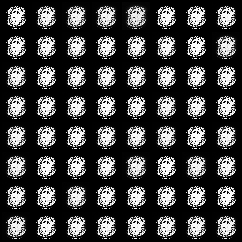



[2/50][0/469]	Loss_D: 0.0189	Loss_G: 7.1787	D(x): 0.9885	D(G(z)): 0.0061 / 0.0025
[2/50][100/469]	Loss_D: 0.0052	Loss_G: 7.3991	D(x): 0.9965	D(G(z)): 0.0013 / 0.0011
[2/50][200/469]	Loss_D: 0.0391	Loss_G: 8.3124	D(x): 0.9799	D(G(z)): 0.0082 / 0.0067
[2/50][300/469]	Loss_D: 0.0177	Loss_G: 5.7777	D(x): 0.9916	D(G(z)): 0.0089 / 0.0053
[2/50][400/469]	Loss_D: 0.0079	Loss_G: 7.5805	D(x): 0.9974	D(G(z)): 0.0051 / 0.0021
====> Test set loss: generator: 0.0102, discriminator: 0.0000
Sample of generated images


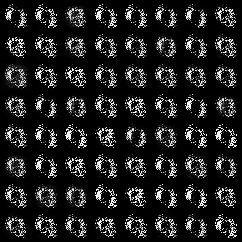



[3/50][0/469]	Loss_D: 0.0225	Loss_G: 8.3898	D(x): 0.9862	D(G(z)): 0.0049 / 0.0024
[3/50][100/469]	Loss_D: 0.0190	Loss_G: 7.2287	D(x): 0.9919	D(G(z)): 0.0085 / 0.0061
[3/50][200/469]	Loss_D: 0.0267	Loss_G: 6.4670	D(x): 0.9877	D(G(z)): 0.0108 / 0.0045
[3/50][300/469]	Loss_D: 0.0106	Loss_G: 6.4700	D(x): 0.9967	D(G(z)): 0.0072 / 0.0029
[3/50][400/469]	Loss_D: 0.0161	Loss_G: 7.6486	D(x): 0.9986	D(G(z)): 0.0139 / 0.0053
====> Test set loss: generator: 0.0081, discriminator: 0.0000
Sample of generated images


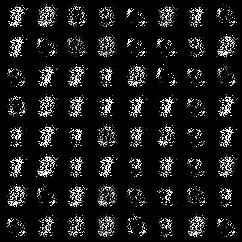



[4/50][0/469]	Loss_D: 0.0104	Loss_G: 6.7411	D(x): 0.9972	D(G(z)): 0.0073 / 0.0042
[4/50][100/469]	Loss_D: 0.0256	Loss_G: 7.6690	D(x): 0.9935	D(G(z)): 0.0177 / 0.0106
[4/50][200/469]	Loss_D: 0.0252	Loss_G: 6.8276	D(x): 0.9905	D(G(z)): 0.0140 / 0.0076
[4/50][300/469]	Loss_D: 0.0083	Loss_G: 7.9600	D(x): 0.9956	D(G(z)): 0.0036 / 0.0016
[4/50][400/469]	Loss_D: 0.0192	Loss_G: 8.0458	D(x): 0.9885	D(G(z)): 0.0066 / 0.0020
====> Test set loss: generator: 0.0090, discriminator: 0.0000
Sample of generated images


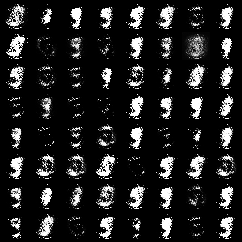



[5/50][0/469]	Loss_D: 0.0191	Loss_G: 7.3619	D(x): 0.9909	D(G(z)): 0.0088 / 0.0058
[5/50][100/469]	Loss_D: 0.0586	Loss_G: 6.0105	D(x): 0.9944	D(G(z)): 0.0472 / 0.0083
[5/50][200/469]	Loss_D: 0.0515	Loss_G: 7.8189	D(x): 0.9756	D(G(z)): 0.0035 / 0.0018
[5/50][300/469]	Loss_D: 0.0593	Loss_G: 6.4739	D(x): 0.9787	D(G(z)): 0.0217 / 0.0181
[5/50][400/469]	Loss_D: 0.0357	Loss_G: 6.4464	D(x): 0.9871	D(G(z)): 0.0188 / 0.0103
====> Test set loss: generator: 0.0090, discriminator: 0.0001
Sample of generated images


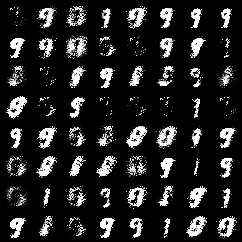



[6/50][0/469]	Loss_D: 0.0288	Loss_G: 7.9856	D(x): 0.9810	D(G(z)): 0.0067 / 0.0021
[6/50][100/469]	Loss_D: 0.0871	Loss_G: 5.4063	D(x): 0.9827	D(G(z)): 0.0489 / 0.0201
[6/50][200/469]	Loss_D: 0.0425	Loss_G: 9.2631	D(x): 0.9734	D(G(z)): 0.0056 / 0.0022
[6/50][300/469]	Loss_D: 0.0542	Loss_G: 6.6307	D(x): 0.9832	D(G(z)): 0.0180 / 0.0119
[6/50][400/469]	Loss_D: 0.0227	Loss_G: 6.2185	D(x): 0.9942	D(G(z)): 0.0156 / 0.0124
====> Test set loss: generator: 0.0080, discriminator: 0.0001
Sample of generated images


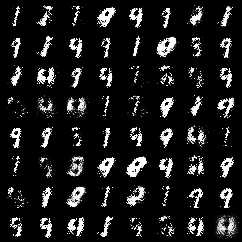



[7/50][0/469]	Loss_D: 0.0389	Loss_G: 6.5582	D(x): 0.9863	D(G(z)): 0.0189 / 0.0121
[7/50][100/469]	Loss_D: 0.0365	Loss_G: 7.8167	D(x): 0.9787	D(G(z)): 0.0074 / 0.0051
[7/50][200/469]	Loss_D: 0.0996	Loss_G: 7.9202	D(x): 0.9591	D(G(z)): 0.0154 / 0.0078
[7/50][300/469]	Loss_D: 0.0530	Loss_G: 5.7836	D(x): 0.9907	D(G(z)): 0.0333 / 0.0204
[7/50][400/469]	Loss_D: 0.0353	Loss_G: 6.2698	D(x): 0.9851	D(G(z)): 0.0148 / 0.0093
====> Test set loss: generator: 0.0089, discriminator: 0.0001
Sample of generated images


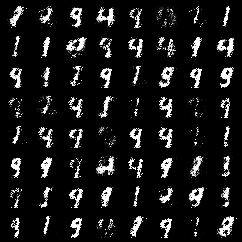



[8/50][0/469]	Loss_D: 0.0303	Loss_G: 7.1602	D(x): 0.9823	D(G(z)): 0.0098 / 0.0092
[8/50][100/469]	Loss_D: 0.0754	Loss_G: 6.3149	D(x): 0.9771	D(G(z)): 0.0266 / 0.0214
[8/50][200/469]	Loss_D: 0.0824	Loss_G: 7.2382	D(x): 0.9702	D(G(z)): 0.0181 / 0.0103
[8/50][300/469]	Loss_D: 0.0666	Loss_G: 6.4360	D(x): 0.9855	D(G(z)): 0.0377 / 0.0190
[8/50][400/469]	Loss_D: 0.1086	Loss_G: 6.7085	D(x): 0.9423	D(G(z)): 0.0181 / 0.0169
====> Test set loss: generator: 0.0084, discriminator: 0.0001
Sample of generated images


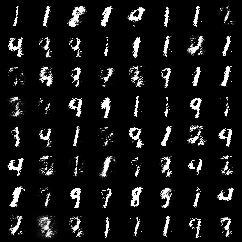



[9/50][0/469]	Loss_D: 0.1817	Loss_G: 7.1115	D(x): 0.9387	D(G(z)): 0.0257 / 0.0173
[9/50][100/469]	Loss_D: 0.1760	Loss_G: 7.1323	D(x): 0.9627	D(G(z)): 0.0644 / 0.0282
[9/50][200/469]	Loss_D: 0.1121	Loss_G: 6.1157	D(x): 0.9770	D(G(z)): 0.0675 / 0.0452
[9/50][300/469]	Loss_D: 0.1063	Loss_G: 6.0153	D(x): 0.9723	D(G(z)): 0.0437 / 0.0268
[9/50][400/469]	Loss_D: 0.0763	Loss_G: 7.4208	D(x): 0.9623	D(G(z)): 0.0146 / 0.0047
====> Test set loss: generator: 0.0068, discriminator: 0.0002
Sample of generated images


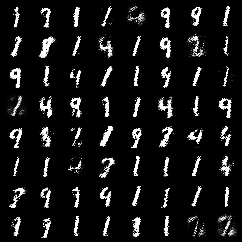



[10/50][0/469]	Loss_D: 0.1674	Loss_G: 5.6708	D(x): 0.9508	D(G(z)): 0.0588 / 0.0336
[10/50][100/469]	Loss_D: 0.1414	Loss_G: 4.6477	D(x): 0.9644	D(G(z)): 0.0633 / 0.0467
[10/50][200/469]	Loss_D: 0.1732	Loss_G: 4.7307	D(x): 0.9339	D(G(z)): 0.0471 / 0.0313
[10/50][300/469]	Loss_D: 0.1496	Loss_G: 5.2945	D(x): 0.9487	D(G(z)): 0.0317 / 0.0412
[10/50][400/469]	Loss_D: 0.1166	Loss_G: 5.2154	D(x): 0.9684	D(G(z)): 0.0470 / 0.0371
====> Test set loss: generator: 0.0061, discriminator: 0.0002
Sample of generated images


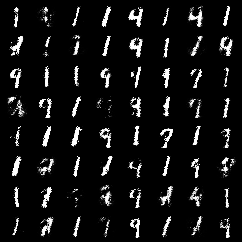



[11/50][0/469]	Loss_D: 0.0763	Loss_G: 4.6515	D(x): 0.9799	D(G(z)): 0.0378 / 0.0427
[11/50][100/469]	Loss_D: 0.3141	Loss_G: 5.0961	D(x): 0.8957	D(G(z)): 0.0358 / 0.0332
[11/50][200/469]	Loss_D: 0.1587	Loss_G: 5.0592	D(x): 0.9410	D(G(z)): 0.0417 / 0.0389
[11/50][300/469]	Loss_D: 0.1628	Loss_G: 5.0509	D(x): 0.9500	D(G(z)): 0.0479 / 0.0346
[11/50][400/469]	Loss_D: 0.2831	Loss_G: 4.2997	D(x): 0.8983	D(G(z)): 0.0512 / 0.0484
====> Test set loss: generator: 0.0054, discriminator: 0.0003
Sample of generated images


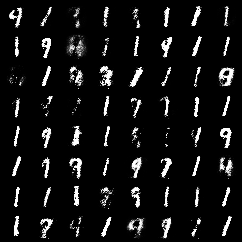



[12/50][0/469]	Loss_D: 0.1798	Loss_G: 4.4813	D(x): 0.9547	D(G(z)): 0.0769 / 0.0507
[12/50][100/469]	Loss_D: 0.1428	Loss_G: 3.8571	D(x): 0.9614	D(G(z)): 0.0672 / 0.0656
[12/50][200/469]	Loss_D: 0.1994	Loss_G: 4.1762	D(x): 0.9491	D(G(z)): 0.0962 / 0.0612
[12/50][300/469]	Loss_D: 0.2095	Loss_G: 4.4237	D(x): 0.9503	D(G(z)): 0.0967 / 0.0598
[12/50][400/469]	Loss_D: 0.1977	Loss_G: 4.3879	D(x): 0.9427	D(G(z)): 0.0576 / 0.0630
====> Test set loss: generator: 0.0060, discriminator: 0.0003
Sample of generated images


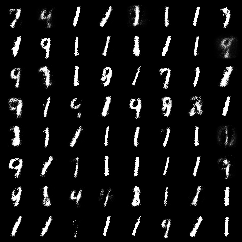



[13/50][0/469]	Loss_D: 0.1201	Loss_G: 5.0296	D(x): 0.9517	D(G(z)): 0.0361 / 0.0278
[13/50][100/469]	Loss_D: 0.2446	Loss_G: 4.3126	D(x): 0.9197	D(G(z)): 0.0684 / 0.0617
[13/50][200/469]	Loss_D: 0.2020	Loss_G: 3.6909	D(x): 0.9628	D(G(z)): 0.1039 / 0.0866
[13/50][300/469]	Loss_D: 0.1893	Loss_G: 4.4584	D(x): 0.9172	D(G(z)): 0.0541 / 0.0417
[13/50][400/469]	Loss_D: 0.3479	Loss_G: 3.7960	D(x): 0.8856	D(G(z)): 0.0806 / 0.0948
====> Test set loss: generator: 0.0056, discriminator: 0.0004
Sample of generated images


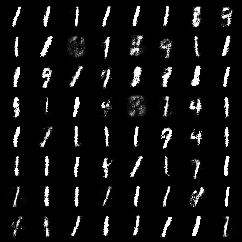



[14/50][0/469]	Loss_D: 0.3151	Loss_G: 4.4910	D(x): 0.9239	D(G(z)): 0.0721 / 0.0564
[14/50][100/469]	Loss_D: 0.2110	Loss_G: 3.7686	D(x): 0.9396	D(G(z)): 0.0897 / 0.0799
[14/50][200/469]	Loss_D: 0.2808	Loss_G: 4.3484	D(x): 0.9381	D(G(z)): 0.0801 / 0.0643
[14/50][300/469]	Loss_D: 0.4196	Loss_G: 3.7624	D(x): 0.8758	D(G(z)): 0.1065 / 0.0786
[14/50][400/469]	Loss_D: 0.3492	Loss_G: 3.7142	D(x): 0.9085	D(G(z)): 0.0924 / 0.0813
====> Test set loss: generator: 0.0044, discriminator: 0.0004
Sample of generated images


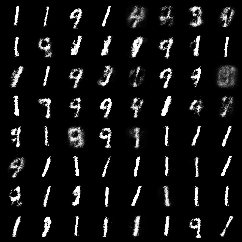



[15/50][0/469]	Loss_D: 0.3273	Loss_G: 3.1879	D(x): 0.9219	D(G(z)): 0.1238 / 0.1119
[15/50][100/469]	Loss_D: 0.3017	Loss_G: 4.2952	D(x): 0.9003	D(G(z)): 0.0510 / 0.0590
[15/50][200/469]	Loss_D: 0.2340	Loss_G: 3.9444	D(x): 0.9331	D(G(z)): 0.0533 / 0.0631
[15/50][300/469]	Loss_D: 0.2579	Loss_G: 4.7423	D(x): 0.9346	D(G(z)): 0.0483 / 0.0459
[15/50][400/469]	Loss_D: 0.2454	Loss_G: 4.9259	D(x): 0.8995	D(G(z)): 0.0331 / 0.0279
====> Test set loss: generator: 0.0044, discriminator: 0.0004
Sample of generated images


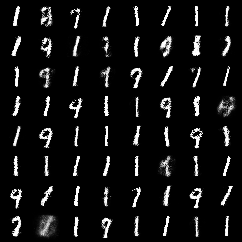



[16/50][0/469]	Loss_D: 0.2711	Loss_G: 3.5417	D(x): 0.9359	D(G(z)): 0.1215 / 0.1061
[16/50][100/469]	Loss_D: 0.2645	Loss_G: 3.9426	D(x): 0.9209	D(G(z)): 0.0718 / 0.0741
[16/50][200/469]	Loss_D: 0.3356	Loss_G: 4.0477	D(x): 0.9434	D(G(z)): 0.1212 / 0.0865
[16/50][300/469]	Loss_D: 0.3628	Loss_G: 3.6362	D(x): 0.8874	D(G(z)): 0.0937 / 0.0884
[16/50][400/469]	Loss_D: 0.2973	Loss_G: 3.5222	D(x): 0.9300	D(G(z)): 0.1216 / 0.0931
====> Test set loss: generator: 0.0050, discriminator: 0.0004
Sample of generated images


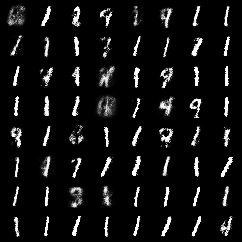



[17/50][0/469]	Loss_D: 0.4035	Loss_G: 3.8869	D(x): 0.8927	D(G(z)): 0.0799 / 0.0767
[17/50][100/469]	Loss_D: 0.2894	Loss_G: 3.9239	D(x): 0.9175	D(G(z)): 0.0737 / 0.0563
[17/50][200/469]	Loss_D: 0.5443	Loss_G: 2.7940	D(x): 0.8788	D(G(z)): 0.1784 / 0.1624
[17/50][300/469]	Loss_D: 0.2161	Loss_G: 4.2364	D(x): 0.9462	D(G(z)): 0.0771 / 0.0617
[17/50][400/469]	Loss_D: 0.3656	Loss_G: 3.6976	D(x): 0.8973	D(G(z)): 0.1016 / 0.0714
====> Test set loss: generator: 0.0052, discriminator: 0.0006
Sample of generated images


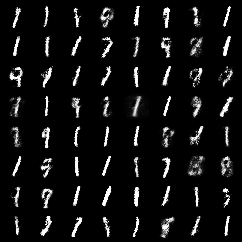



[18/50][0/469]	Loss_D: 0.4177	Loss_G: 4.2705	D(x): 0.8816	D(G(z)): 0.0791 / 0.0594
[18/50][100/469]	Loss_D: 0.2583	Loss_G: 4.3849	D(x): 0.9082	D(G(z)): 0.0501 / 0.0423
[18/50][200/469]	Loss_D: 0.3768	Loss_G: 3.0256	D(x): 0.8994	D(G(z)): 0.1249 / 0.1280
[18/50][300/469]	Loss_D: 0.4258	Loss_G: 3.3540	D(x): 0.8958	D(G(z)): 0.1522 / 0.1063
[18/50][400/469]	Loss_D: 0.2983	Loss_G: 3.2523	D(x): 0.9291	D(G(z)): 0.1275 / 0.0922
====> Test set loss: generator: 0.0037, discriminator: 0.0006
Sample of generated images


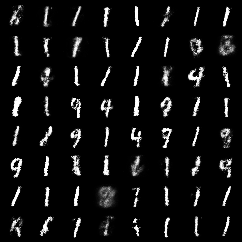



[19/50][0/469]	Loss_D: 0.3510	Loss_G: 2.9377	D(x): 0.9090	D(G(z)): 0.1177 / 0.1055
[19/50][100/469]	Loss_D: 0.4670	Loss_G: 3.9477	D(x): 0.8864	D(G(z)): 0.0964 / 0.0651
[19/50][200/469]	Loss_D: 0.2451	Loss_G: 3.8881	D(x): 0.9278	D(G(z)): 0.0882 / 0.0758
[19/50][300/469]	Loss_D: 0.4658	Loss_G: 2.9920	D(x): 0.9234	D(G(z)): 0.2114 / 0.1530
[19/50][400/469]	Loss_D: 0.3452	Loss_G: 3.5210	D(x): 0.9048	D(G(z)): 0.1128 / 0.0762
====> Test set loss: generator: 0.0045, discriminator: 0.0005
Sample of generated images


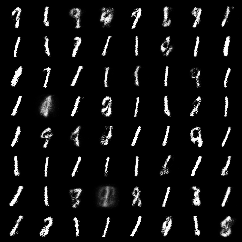



[20/50][0/469]	Loss_D: 0.3595	Loss_G: 3.6500	D(x): 0.9241	D(G(z)): 0.1202 / 0.0941
[20/50][100/469]	Loss_D: 0.3556	Loss_G: 3.1351	D(x): 0.9170	D(G(z)): 0.1484 / 0.1006
[20/50][200/469]	Loss_D: 0.4281	Loss_G: 3.2644	D(x): 0.8717	D(G(z)): 0.1288 / 0.1013
[20/50][300/469]	Loss_D: 0.4170	Loss_G: 3.8183	D(x): 0.8893	D(G(z)): 0.0974 / 0.0789
[20/50][400/469]	Loss_D: 0.3719	Loss_G: 3.6275	D(x): 0.9040	D(G(z)): 0.1201 / 0.0746
====> Test set loss: generator: 0.0043, discriminator: 0.0006
Sample of generated images


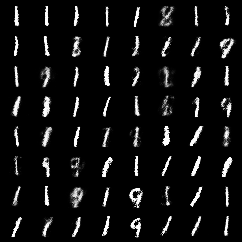



[21/50][0/469]	Loss_D: 0.4034	Loss_G: 3.3375	D(x): 0.8847	D(G(z)): 0.1003 / 0.1040
[21/50][100/469]	Loss_D: 0.3781	Loss_G: 3.1911	D(x): 0.8971	D(G(z)): 0.1156 / 0.1085
[21/50][200/469]	Loss_D: 0.5039	Loss_G: 3.6549	D(x): 0.8415	D(G(z)): 0.0769 / 0.0744
[21/50][300/469]	Loss_D: 0.3415	Loss_G: 3.4324	D(x): 0.8953	D(G(z)): 0.0855 / 0.0726
[21/50][400/469]	Loss_D: 0.4009	Loss_G: 3.0755	D(x): 0.8826	D(G(z)): 0.1166 / 0.1012
====> Test set loss: generator: 0.0042, discriminator: 0.0006
Sample of generated images


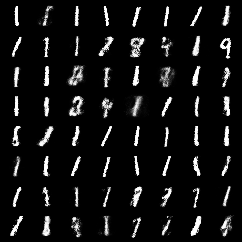



[22/50][0/469]	Loss_D: 0.3687	Loss_G: 3.4680	D(x): 0.9154	D(G(z)): 0.1182 / 0.0887
[22/50][100/469]	Loss_D: 0.2122	Loss_G: 4.0405	D(x): 0.9481	D(G(z)): 0.1022 / 0.0737
[22/50][200/469]	Loss_D: 0.6698	Loss_G: 2.5904	D(x): 0.8381	D(G(z)): 0.1538 / 0.1538
[22/50][300/469]	Loss_D: 0.4169	Loss_G: 3.2872	D(x): 0.8825	D(G(z)): 0.1260 / 0.0945
[22/50][400/469]	Loss_D: 0.4638	Loss_G: 3.3030	D(x): 0.8677	D(G(z)): 0.1045 / 0.0899
====> Test set loss: generator: 0.0040, discriminator: 0.0005
Sample of generated images


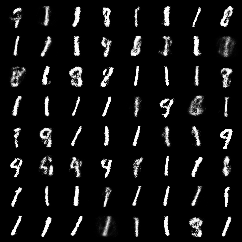



[23/50][0/469]	Loss_D: 0.2764	Loss_G: 3.4228	D(x): 0.9281	D(G(z)): 0.0999 / 0.0835
[23/50][100/469]	Loss_D: 0.4561	Loss_G: 3.3693	D(x): 0.8897	D(G(z)): 0.1182 / 0.0957
[23/50][200/469]	Loss_D: 0.6635	Loss_G: 3.0430	D(x): 0.8328	D(G(z)): 0.1186 / 0.1113
[23/50][300/469]	Loss_D: 0.3033	Loss_G: 3.4476	D(x): 0.9073	D(G(z)): 0.0825 / 0.0678
[23/50][400/469]	Loss_D: 0.3218	Loss_G: 3.1617	D(x): 0.9055	D(G(z)): 0.1247 / 0.1036
====> Test set loss: generator: 0.0042, discriminator: 0.0006
Sample of generated images


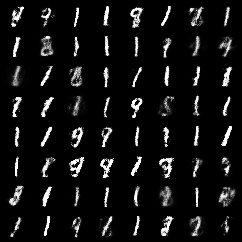



[24/50][0/469]	Loss_D: 0.2635	Loss_G: 3.3584	D(x): 0.9289	D(G(z)): 0.0971 / 0.0841
[24/50][100/469]	Loss_D: 0.4145	Loss_G: 3.6410	D(x): 0.8829	D(G(z)): 0.0900 / 0.0797
[24/50][200/469]	Loss_D: 0.5890	Loss_G: 3.4619	D(x): 0.8442	D(G(z)): 0.0962 / 0.0853
[24/50][300/469]	Loss_D: 0.4919	Loss_G: 3.5347	D(x): 0.8822	D(G(z)): 0.1030 / 0.0874
[24/50][400/469]	Loss_D: 0.4314	Loss_G: 2.4107	D(x): 0.9092	D(G(z)): 0.1886 / 0.1793
====> Test set loss: generator: 0.0036, discriminator: 0.0006
Sample of generated images


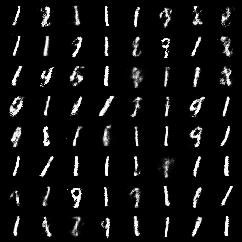



[25/50][0/469]	Loss_D: 0.3972	Loss_G: 2.9431	D(x): 0.9186	D(G(z)): 0.1545 / 0.1254
[25/50][100/469]	Loss_D: 0.4974	Loss_G: 2.7155	D(x): 0.8601	D(G(z)): 0.1259 / 0.1247
[25/50][200/469]	Loss_D: 0.4214	Loss_G: 3.1745	D(x): 0.8855	D(G(z)): 0.1140 / 0.1043
[25/50][300/469]	Loss_D: 0.5211	Loss_G: 2.7990	D(x): 0.8701	D(G(z)): 0.1595 / 0.1370
[25/50][400/469]	Loss_D: 0.3433	Loss_G: 3.4325	D(x): 0.8864	D(G(z)): 0.0834 / 0.0791
====> Test set loss: generator: 0.0038, discriminator: 0.0006
Sample of generated images


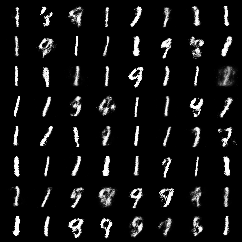



[26/50][0/469]	Loss_D: 0.3675	Loss_G: 3.0780	D(x): 0.8914	D(G(z)): 0.1169 / 0.1032
[26/50][100/469]	Loss_D: 0.4160	Loss_G: 2.9008	D(x): 0.8977	D(G(z)): 0.1421 / 0.1276
[26/50][200/469]	Loss_D: 0.3299	Loss_G: 3.5315	D(x): 0.8951	D(G(z)): 0.0789 / 0.0719
[26/50][300/469]	Loss_D: 0.4575	Loss_G: 2.8279	D(x): 0.8656	D(G(z)): 0.1201 / 0.1260
[26/50][400/469]	Loss_D: 0.3948	Loss_G: 2.9098	D(x): 0.9136	D(G(z)): 0.1323 / 0.1137
====> Test set loss: generator: 0.0043, discriminator: 0.0007
Sample of generated images


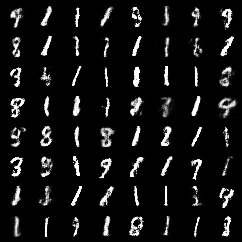



[27/50][0/469]	Loss_D: 0.4394	Loss_G: 3.5179	D(x): 0.8621	D(G(z)): 0.0831 / 0.0739
[27/50][100/469]	Loss_D: 0.4359	Loss_G: 3.0990	D(x): 0.9094	D(G(z)): 0.1506 / 0.1348
[27/50][200/469]	Loss_D: 0.5266	Loss_G: 3.0634	D(x): 0.8701	D(G(z)): 0.1420 / 0.1153
[27/50][300/469]	Loss_D: 0.4351	Loss_G: 2.8537	D(x): 0.8851	D(G(z)): 0.1207 / 0.1179
[27/50][400/469]	Loss_D: 0.5957	Loss_G: 3.2135	D(x): 0.8180	D(G(z)): 0.1036 / 0.1018
====> Test set loss: generator: 0.0030, discriminator: 0.0007
Sample of generated images


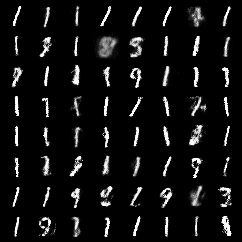



[28/50][0/469]	Loss_D: 0.4977	Loss_G: 2.4818	D(x): 0.8933	D(G(z)): 0.1920 / 0.1809
[28/50][100/469]	Loss_D: 0.4128	Loss_G: 2.8023	D(x): 0.8961	D(G(z)): 0.1363 / 0.1327
[28/50][200/469]	Loss_D: 0.4398	Loss_G: 3.2757	D(x): 0.8866	D(G(z)): 0.1264 / 0.0994
[28/50][300/469]	Loss_D: 0.3995	Loss_G: 3.5524	D(x): 0.8662	D(G(z)): 0.0758 / 0.0744
[28/50][400/469]	Loss_D: 0.5322	Loss_G: 2.6183	D(x): 0.8837	D(G(z)): 0.1579 / 0.1397
====> Test set loss: generator: 0.0040, discriminator: 0.0006
Sample of generated images


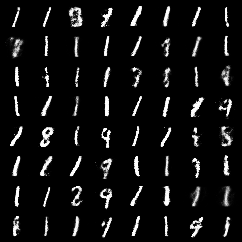



[29/50][0/469]	Loss_D: 0.4528	Loss_G: 3.3105	D(x): 0.8918	D(G(z)): 0.1283 / 0.0938
[29/50][100/469]	Loss_D: 0.4686	Loss_G: 2.8418	D(x): 0.8804	D(G(z)): 0.1437 / 0.1339
[29/50][200/469]	Loss_D: 0.3529	Loss_G: 3.2519	D(x): 0.8999	D(G(z)): 0.1251 / 0.0984
[29/50][300/469]	Loss_D: 0.6312	Loss_G: 3.1823	D(x): 0.8141	D(G(z)): 0.1140 / 0.1123
[29/50][400/469]	Loss_D: 0.3074	Loss_G: 3.1273	D(x): 0.9081	D(G(z)): 0.1223 / 0.0914
====> Test set loss: generator: 0.0038, discriminator: 0.0007
Sample of generated images


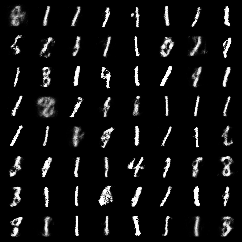



[30/50][0/469]	Loss_D: 0.6067	Loss_G: 3.0170	D(x): 0.8428	D(G(z)): 0.1454 / 0.1396
[30/50][100/469]	Loss_D: 0.5116	Loss_G: 3.0503	D(x): 0.8561	D(G(z)): 0.1657 / 0.1195
[30/50][200/469]	Loss_D: 0.4850	Loss_G: 2.5006	D(x): 0.8877	D(G(z)): 0.1822 / 0.1628
[30/50][300/469]	Loss_D: 0.3765	Loss_G: 3.1765	D(x): 0.9064	D(G(z)): 0.1262 / 0.0992
[30/50][400/469]	Loss_D: 0.5028	Loss_G: 3.5215	D(x): 0.8535	D(G(z)): 0.0818 / 0.0676
====> Test set loss: generator: 0.0039, discriminator: 0.0006
Sample of generated images


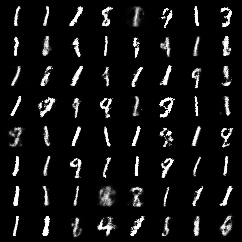



[31/50][0/469]	Loss_D: 0.4262	Loss_G: 3.0186	D(x): 0.8734	D(G(z)): 0.1261 / 0.1220
[31/50][100/469]	Loss_D: 0.5053	Loss_G: 2.7315	D(x): 0.8429	D(G(z)): 0.1330 / 0.1290
[31/50][200/469]	Loss_D: 0.3952	Loss_G: 3.2614	D(x): 0.8891	D(G(z)): 0.1008 / 0.0932
[31/50][300/469]	Loss_D: 0.3901	Loss_G: 2.9037	D(x): 0.8996	D(G(z)): 0.1460 / 0.1258
[31/50][400/469]	Loss_D: 0.6410	Loss_G: 2.8260	D(x): 0.8644	D(G(z)): 0.1579 / 0.1324
====> Test set loss: generator: 0.0039, discriminator: 0.0006
Sample of generated images


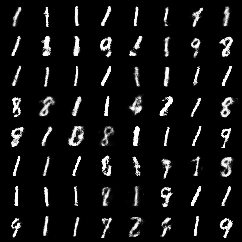



[32/50][0/469]	Loss_D: 0.4033	Loss_G: 3.3705	D(x): 0.8938	D(G(z)): 0.1150 / 0.0906
[32/50][100/469]	Loss_D: 0.3955	Loss_G: 3.1574	D(x): 0.8879	D(G(z)): 0.1224 / 0.1083
[32/50][200/469]	Loss_D: 0.6688	Loss_G: 2.5152	D(x): 0.8090	D(G(z)): 0.1365 / 0.1410
[32/50][300/469]	Loss_D: 0.4582	Loss_G: 2.6020	D(x): 0.8761	D(G(z)): 0.1550 / 0.1280
[32/50][400/469]	Loss_D: 0.3845	Loss_G: 3.2577	D(x): 0.8725	D(G(z)): 0.0886 / 0.0842
====> Test set loss: generator: 0.0037, discriminator: 0.0007
Sample of generated images


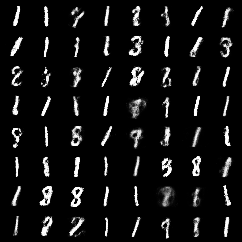



[33/50][0/469]	Loss_D: 0.4043	Loss_G: 3.1382	D(x): 0.8845	D(G(z)): 0.1339 / 0.0962
[33/50][100/469]	Loss_D: 0.4415	Loss_G: 2.7355	D(x): 0.8955	D(G(z)): 0.1474 / 0.1255
[33/50][200/469]	Loss_D: 0.4376	Loss_G: 2.7044	D(x): 0.9034	D(G(z)): 0.1524 / 0.1270
[33/50][300/469]	Loss_D: 0.3564	Loss_G: 3.1602	D(x): 0.8919	D(G(z)): 0.1037 / 0.0825
[33/50][400/469]	Loss_D: 0.4470	Loss_G: 2.3904	D(x): 0.8893	D(G(z)): 0.1744 / 0.1583
====> Test set loss: generator: 0.0030, discriminator: 0.0007
Sample of generated images


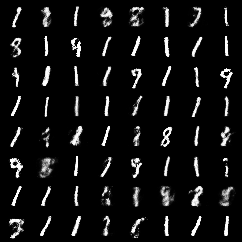



[34/50][0/469]	Loss_D: 0.5761	Loss_G: 2.2174	D(x): 0.8590	D(G(z)): 0.2057 / 0.1940
[34/50][100/469]	Loss_D: 0.5814	Loss_G: 2.2359	D(x): 0.8896	D(G(z)): 0.2321 / 0.1938
[34/50][200/469]	Loss_D: 0.6315	Loss_G: 2.5043	D(x): 0.8766	D(G(z)): 0.1839 / 0.1721
[34/50][300/469]	Loss_D: 0.4026	Loss_G: 2.7073	D(x): 0.8641	D(G(z)): 0.1341 / 0.1261
[34/50][400/469]	Loss_D: 0.3948	Loss_G: 2.4900	D(x): 0.8888	D(G(z)): 0.1584 / 0.1535
====> Test set loss: generator: 0.0039, discriminator: 0.0006
Sample of generated images


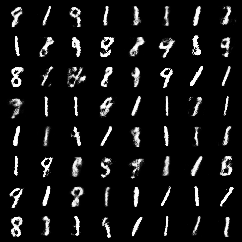



[35/50][0/469]	Loss_D: 0.4276	Loss_G: 2.8836	D(x): 0.8763	D(G(z)): 0.1314 / 0.1238
[35/50][100/469]	Loss_D: 0.5719	Loss_G: 2.0875	D(x): 0.8593	D(G(z)): 0.2028 / 0.2004
[35/50][200/469]	Loss_D: 0.4004	Loss_G: 2.9671	D(x): 0.8899	D(G(z)): 0.1375 / 0.1121
[35/50][300/469]	Loss_D: 0.5556	Loss_G: 2.7601	D(x): 0.8423	D(G(z)): 0.1171 / 0.1207
[35/50][400/469]	Loss_D: 0.4342	Loss_G: 3.3970	D(x): 0.8418	D(G(z)): 0.0876 / 0.0739
====> Test set loss: generator: 0.0039, discriminator: 0.0007
Sample of generated images


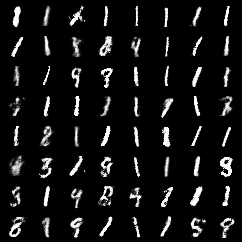



[36/50][0/469]	Loss_D: 0.4928	Loss_G: 3.0221	D(x): 0.8341	D(G(z)): 0.1093 / 0.1126
[36/50][100/469]	Loss_D: 0.5932	Loss_G: 2.6913	D(x): 0.8656	D(G(z)): 0.2081 / 0.1514
[36/50][200/469]	Loss_D: 0.4261	Loss_G: 3.1194	D(x): 0.8806	D(G(z)): 0.1260 / 0.1135
[36/50][300/469]	Loss_D: 0.4562	Loss_G: 2.8486	D(x): 0.8708	D(G(z)): 0.1325 / 0.1101
[36/50][400/469]	Loss_D: 0.4501	Loss_G: 3.1742	D(x): 0.8688	D(G(z)): 0.1159 / 0.1023
====> Test set loss: generator: 0.0032, discriminator: 0.0007
Sample of generated images


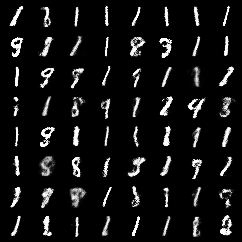



[37/50][0/469]	Loss_D: 0.4417	Loss_G: 2.6321	D(x): 0.8649	D(G(z)): 0.1543 / 0.1424
[37/50][100/469]	Loss_D: 0.4886	Loss_G: 2.5888	D(x): 0.8552	D(G(z)): 0.1528 / 0.1598
[37/50][200/469]	Loss_D: 0.4477	Loss_G: 3.0951	D(x): 0.8570	D(G(z)): 0.1245 / 0.1060
[37/50][300/469]	Loss_D: 0.4103	Loss_G: 2.7149	D(x): 0.8722	D(G(z)): 0.1195 / 0.1277
[37/50][400/469]	Loss_D: 0.4289	Loss_G: 3.0099	D(x): 0.8742	D(G(z)): 0.1056 / 0.0998
====> Test set loss: generator: 0.0032, discriminator: 0.0006
Sample of generated images


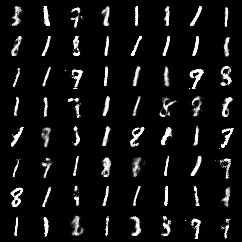



[38/50][0/469]	Loss_D: 0.4608	Loss_G: 2.4139	D(x): 0.8596	D(G(z)): 0.1629 / 0.1626
[38/50][100/469]	Loss_D: 0.5060	Loss_G: 3.0099	D(x): 0.8451	D(G(z)): 0.1180 / 0.1092
[38/50][200/469]	Loss_D: 0.5301	Loss_G: 2.8378	D(x): 0.8198	D(G(z)): 0.1184 / 0.1161
[38/50][300/469]	Loss_D: 0.3746	Loss_G: 2.6301	D(x): 0.8880	D(G(z)): 0.1385 / 0.1346
[38/50][400/469]	Loss_D: 0.6183	Loss_G: 2.4629	D(x): 0.8126	D(G(z)): 0.1712 / 0.1673
====> Test set loss: generator: 0.0035, discriminator: 0.0007
Sample of generated images


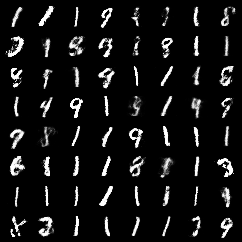



[39/50][0/469]	Loss_D: 0.4367	Loss_G: 2.7330	D(x): 0.8815	D(G(z)): 0.1497 / 0.1300
[39/50][100/469]	Loss_D: 0.3944	Loss_G: 2.9799	D(x): 0.8666	D(G(z)): 0.1089 / 0.0994
[39/50][200/469]	Loss_D: 0.5626	Loss_G: 2.8036	D(x): 0.8202	D(G(z)): 0.1401 / 0.1340
[39/50][300/469]	Loss_D: 0.5212	Loss_G: 2.7766	D(x): 0.8584	D(G(z)): 0.1240 / 0.1138
[39/50][400/469]	Loss_D: 0.5208	Loss_G: 3.1340	D(x): 0.8321	D(G(z)): 0.1154 / 0.1074
====> Test set loss: generator: 0.0037, discriminator: 0.0007
Sample of generated images


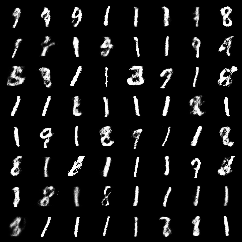



[40/50][0/469]	Loss_D: 0.4784	Loss_G: 2.9447	D(x): 0.8474	D(G(z)): 0.1180 / 0.1118
[40/50][100/469]	Loss_D: 0.4347	Loss_G: 2.6670	D(x): 0.8778	D(G(z)): 0.1581 / 0.1376
[40/50][200/469]	Loss_D: 0.4857	Loss_G: 2.4051	D(x): 0.8628	D(G(z)): 0.1782 / 0.1583
[40/50][300/469]	Loss_D: 0.4241	Loss_G: 2.8608	D(x): 0.8925	D(G(z)): 0.1377 / 0.1220
[40/50][400/469]	Loss_D: 0.4939	Loss_G: 3.1532	D(x): 0.8518	D(G(z)): 0.0974 / 0.0931
====> Test set loss: generator: 0.0038, discriminator: 0.0008
Sample of generated images


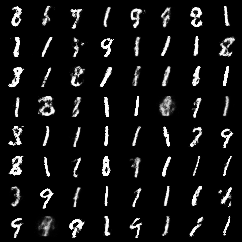



[41/50][0/469]	Loss_D: 0.6556	Loss_G: 2.8026	D(x): 0.8116	D(G(z)): 0.1296 / 0.1380
[41/50][100/469]	Loss_D: 0.3840	Loss_G: 2.7061	D(x): 0.8906	D(G(z)): 0.1440 / 0.1302
[41/50][200/469]	Loss_D: 0.5544	Loss_G: 2.9948	D(x): 0.8288	D(G(z)): 0.1268 / 0.1209
[41/50][300/469]	Loss_D: 0.3719	Loss_G: 2.8109	D(x): 0.9019	D(G(z)): 0.1478 / 0.1192
[41/50][400/469]	Loss_D: 0.4517	Loss_G: 2.7903	D(x): 0.8482	D(G(z)): 0.1455 / 0.1358
====> Test set loss: generator: 0.0035, discriminator: 0.0006
Sample of generated images


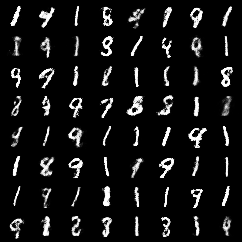



[42/50][0/469]	Loss_D: 0.3198	Loss_G: 2.9664	D(x): 0.8927	D(G(z)): 0.1226 / 0.1054
[42/50][100/469]	Loss_D: 0.4786	Loss_G: 2.7092	D(x): 0.8591	D(G(z)): 0.1456 / 0.1348
[42/50][200/469]	Loss_D: 0.4750	Loss_G: 2.9820	D(x): 0.8606	D(G(z)): 0.1401 / 0.1142
[42/50][300/469]	Loss_D: 0.5113	Loss_G: 2.7457	D(x): 0.8610	D(G(z)): 0.1496 / 0.1471
[42/50][400/469]	Loss_D: 0.4612	Loss_G: 2.4994	D(x): 0.8602	D(G(z)): 0.1493 / 0.1428
====> Test set loss: generator: 0.0038, discriminator: 0.0007
Sample of generated images


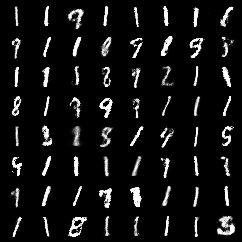



[43/50][0/469]	Loss_D: 0.3548	Loss_G: 3.1832	D(x): 0.8567	D(G(z)): 0.0990 / 0.0802
[43/50][100/469]	Loss_D: 0.4408	Loss_G: 2.8859	D(x): 0.8591	D(G(z)): 0.1260 / 0.1100
[43/50][200/469]	Loss_D: 0.5082	Loss_G: 2.8262	D(x): 0.8851	D(G(z)): 0.1801 / 0.1500
[43/50][300/469]	Loss_D: 0.4867	Loss_G: 2.8279	D(x): 0.8553	D(G(z)): 0.1187 / 0.1170
[43/50][400/469]	Loss_D: 0.3604	Loss_G: 3.1365	D(x): 0.8688	D(G(z)): 0.1016 / 0.0864
====> Test set loss: generator: 0.0032, discriminator: 0.0007
Sample of generated images


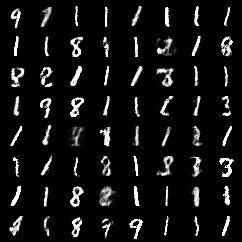



[44/50][0/469]	Loss_D: 0.4305	Loss_G: 2.4426	D(x): 0.9095	D(G(z)): 0.1868 / 0.1749
[44/50][100/469]	Loss_D: 0.4748	Loss_G: 3.1173	D(x): 0.8450	D(G(z)): 0.1189 / 0.1111
[44/50][200/469]	Loss_D: 0.5135	Loss_G: 2.9001	D(x): 0.8290	D(G(z)): 0.1093 / 0.1062
[44/50][300/469]	Loss_D: 0.4036	Loss_G: 2.8512	D(x): 0.9050	D(G(z)): 0.1449 / 0.1253
[44/50][400/469]	Loss_D: 0.4872	Loss_G: 2.6876	D(x): 0.8592	D(G(z)): 0.1510 / 0.1365
====> Test set loss: generator: 0.0038, discriminator: 0.0007
Sample of generated images


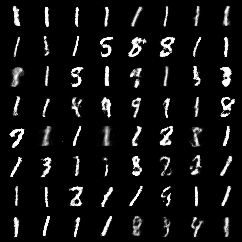



[45/50][0/469]	Loss_D: 0.4305	Loss_G: 2.8612	D(x): 0.8386	D(G(z)): 0.1177 / 0.1050
[45/50][100/469]	Loss_D: 0.3841	Loss_G: 3.0831	D(x): 0.8720	D(G(z)): 0.1177 / 0.0974
[45/50][200/469]	Loss_D: 0.4544	Loss_G: 2.5424	D(x): 0.8599	D(G(z)): 0.1451 / 0.1467
[45/50][300/469]	Loss_D: 0.5130	Loss_G: 2.6525	D(x): 0.8676	D(G(z)): 0.1639 / 0.1384
[45/50][400/469]	Loss_D: 0.3931	Loss_G: 2.5238	D(x): 0.8906	D(G(z)): 0.1545 / 0.1394
====> Test set loss: generator: 0.0035, discriminator: 0.0007
Sample of generated images


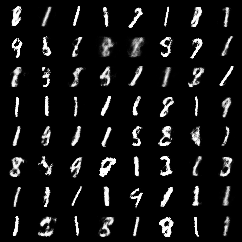



[46/50][0/469]	Loss_D: 0.4907	Loss_G: 2.6843	D(x): 0.8510	D(G(z)): 0.1395 / 0.1342
[46/50][100/469]	Loss_D: 0.5287	Loss_G: 2.9582	D(x): 0.8401	D(G(z)): 0.1293 / 0.1239
[46/50][200/469]	Loss_D: 0.4100	Loss_G: 2.5471	D(x): 0.8774	D(G(z)): 0.1572 / 0.1412
[46/50][300/469]	Loss_D: 0.5269	Loss_G: 2.8988	D(x): 0.8527	D(G(z)): 0.1408 / 0.1304
[46/50][400/469]	Loss_D: 0.3634	Loss_G: 3.0419	D(x): 0.8734	D(G(z)): 0.0998 / 0.0940
====> Test set loss: generator: 0.0037, discriminator: 0.0006
Sample of generated images


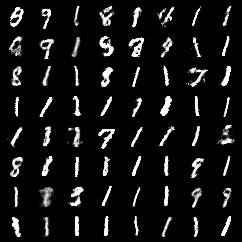



[47/50][0/469]	Loss_D: 0.5559	Loss_G: 2.7961	D(x): 0.8440	D(G(z)): 0.1568 / 0.1471
[47/50][100/469]	Loss_D: 0.4972	Loss_G: 2.4894	D(x): 0.8541	D(G(z)): 0.1588 / 0.1575
[47/50][200/469]	Loss_D: 0.5358	Loss_G: 2.6181	D(x): 0.8464	D(G(z)): 0.1802 / 0.1614
[47/50][300/469]	Loss_D: 0.4679	Loss_G: 2.5758	D(x): 0.8438	D(G(z)): 0.1587 / 0.1442
[47/50][400/469]	Loss_D: 0.3386	Loss_G: 2.9021	D(x): 0.9020	D(G(z)): 0.1238 / 0.1184
====> Test set loss: generator: 0.0031, discriminator: 0.0007
Sample of generated images


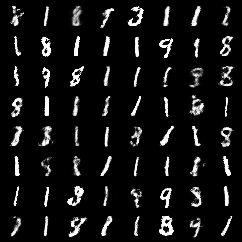



[48/50][0/469]	Loss_D: 0.4603	Loss_G: 2.4460	D(x): 0.8897	D(G(z)): 0.1955 / 0.1584
[48/50][100/469]	Loss_D: 0.5956	Loss_G: 2.6816	D(x): 0.8253	D(G(z)): 0.1714 / 0.1612
[48/50][200/469]	Loss_D: 0.4758	Loss_G: 2.5731	D(x): 0.8595	D(G(z)): 0.1535 / 0.1436
[48/50][300/469]	Loss_D: 0.6819	Loss_G: 2.6910	D(x): 0.7950	D(G(z)): 0.1569 / 0.1664
[48/50][400/469]	Loss_D: 0.4519	Loss_G: 2.6564	D(x): 0.8704	D(G(z)): 0.1751 / 0.1572
====> Test set loss: generator: 0.0036, discriminator: 0.0007
Sample of generated images


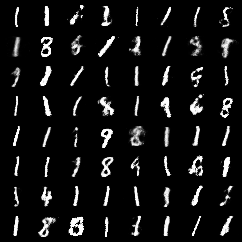



[49/50][0/469]	Loss_D: 0.4826	Loss_G: 2.8162	D(x): 0.8549	D(G(z)): 0.1337 / 0.1262
[49/50][100/469]	Loss_D: 0.6448	Loss_G: 2.7442	D(x): 0.8305	D(G(z)): 0.1699 / 0.1382
[49/50][200/469]	Loss_D: 0.4816	Loss_G: 2.6960	D(x): 0.8798	D(G(z)): 0.1612 / 0.1443
[49/50][300/469]	Loss_D: 0.4665	Loss_G: 2.5730	D(x): 0.8686	D(G(z)): 0.1616 / 0.1429
[49/50][400/469]	Loss_D: 0.4376	Loss_G: 2.7514	D(x): 0.8923	D(G(z)): 0.1598 / 0.1487
====> Test set loss: generator: 0.0037, discriminator: 0.0007
Sample of generated images


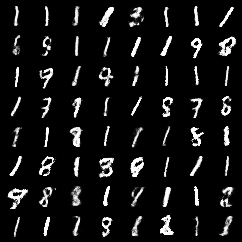



[50/50][0/469]	Loss_D: 0.6580	Loss_G: 2.7743	D(x): 0.7931	D(G(z)): 0.1283 / 0.1334
[50/50][100/469]	Loss_D: 0.6000	Loss_G: 2.3849	D(x): 0.7964	D(G(z)): 0.1814 / 0.1651
[50/50][200/469]	Loss_D: 0.5268	Loss_G: 2.4932	D(x): 0.8754	D(G(z)): 0.1833 / 0.1570
[50/50][300/469]	Loss_D: 0.5019	Loss_G: 2.5864	D(x): 0.8830	D(G(z)): 0.1978 / 0.1826
[50/50][400/469]	Loss_D: 0.4267	Loss_G: 2.9912	D(x): 0.8451	D(G(z)): 0.1131 / 0.1085
====> Test set loss: generator: 0.0038, discriminator: 0.0007
Sample of generated images


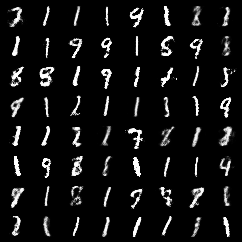

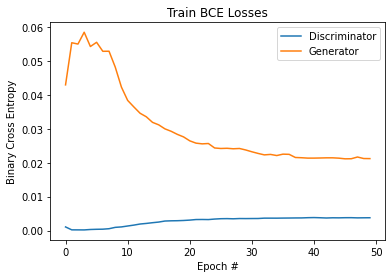

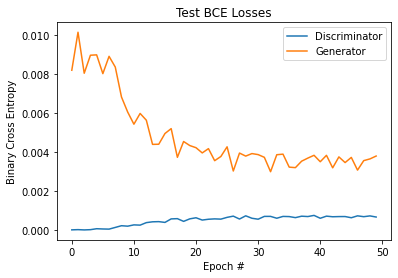

In [ ]:
# train and test gan
epochs=50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()



In terms of the sample generated images, GAN has clearer edges in its results while VAE has blurry edges. The fuzzy edge is due to latent collapse. Around the edges, VAE predicts something between black and white around the edges to minimize training loss, which creates a blurred effect. On the other hand, GAN doesn't have as much bias. If the generator creates images with blurry edges, the discriminator will be able to differentiate the fake and real images based on that attribute. Hence, the generator will "learn" to produce outputs that are crispy on the edges so the discriminator can't differentiate between real and fake. 